# Project 5: Panorama Stitching

[https://github.com/meterglost/HCMUT-CO3057-DigitalImageProcessing-ComputerVision](https://github.com/meterglost/HCMUT-CO3057-DigitalImageProcessing-ComputerVision/tree/main/project/project5.ipynb)

## Introduction

Image stitching, also known as photo stitching, is the technique of combining multiple images into a single, expansive image. Each individual images you stitch together need to have overlapping areas. This overlap allows the stitching software to find matching features between the images and align them precisely to create larger image which is often called a panorama.

Image stitching process includes following steps:

1.  Feature Detection and Matching:

    The algorithm scans each image to identify distinct visual features like corners, edges, or patterns. Then, it finds matching features between the overlapping areas of the images.

2.  Image Registration and Transformation:

    Based on the corresponding features, the algorithm calculates how each image needs to be transformed (rotated, shifted) to align perfectly.

3.  Image Warping:

    Each image is then warped (distorted) according to the calculated transformations to create a unified scene.

4.  Blending:

    This is where the seams between the images are hidden. The algorithm blends the overlapping regions of the warped images, adjusting color, brightness, and exposure for a natural-looking transition.
    
At each step, there are various methods can be use with there own pros and cons to serve different purposes.

In this projeject, beside trying the simple provided API to do image stitching from OpenCV library, we also implement simple image stitching to evaluate feature detecting methods.

## Setup

In [1]:
%pip install --quiet opencv-python-headless numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2 as cv
import numpy as np
from IPython.display import display, Image

## Sample images

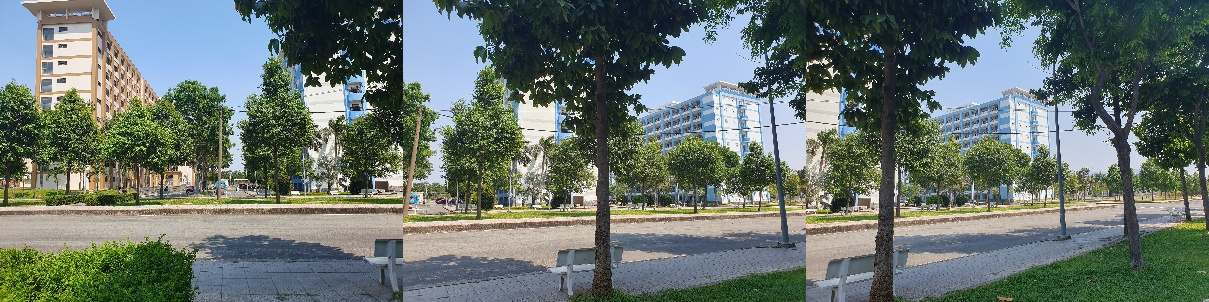

In [35]:
imgs = [
    cv.resize(cv.imread('../sample/20240409_095607.jpg'), (0, 0), fx = 0.1, fy = 0.1),
    cv.resize(cv.imread('../sample/20240409_095602.jpg'), (0, 0), fx = 0.1, fy = 0.1),
    cv.resize(cv.imread('../sample/20240409_095557.jpg'), (0, 0), fx = 0.1, fy = 0.1),
]

display(Image(cv.imencode('.jpg', cv.hconcat(imgs))[1].tobytes()))

## Using provided simple API

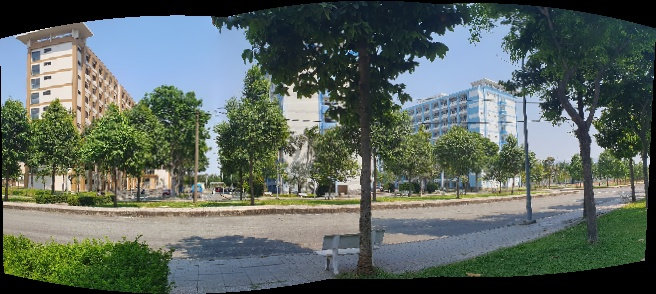

In [53]:
stitchy = cv.Stitcher.create()
( dummy, output ) = stitchy.stitch(imgs)

if dummy == cv.STITCHER_OK:
    display(Image(cv.imencode('.jpg', output)[1].tobytes()))

## Using SIFT for extracting features

- Strengths:
  - Highly accurate: SIFT excels at finding unique keypoints even in challenging scenarios like varying scales and rotations
  - Robust: Works well with low-light or noisy images.
  - Widely used: Established method with plenty of documentation and resources available.

- Weaknesses:
  - Slower processing time compared to BRISK.
  - More computationally expensive.

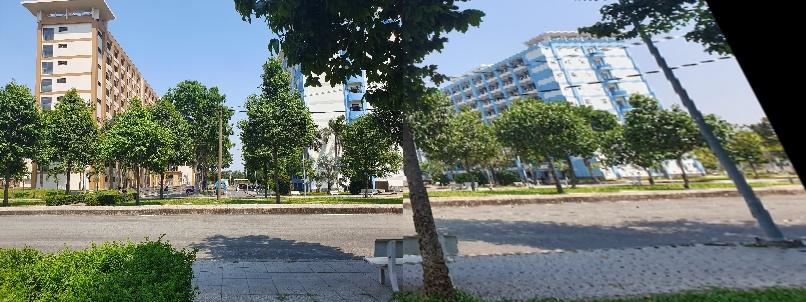

In [84]:
sift = cv.SIFT.create()

kp1, des1 = sift.detectAndCompute(imgs[0], None)
kp2, des2 = sift.detectAndCompute(imgs[1], None)

matcher = cv.BFMatcher()
matches = matcher.knnMatch(des1, des2, k = 2)
matches = np.asarray([match for match in matches if match[0].distance < 0.5 * match[1].distance])

if len(matches[:,0]) < 4:
    raise AssertionError("Can't find enough keypoints.")

src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)

H, masked = cv.findHomography(dst, src, cv.RANSAC, 5.0)

output = cv.warpPerspective(imgs[1], H, (imgs[1].shape[1] + imgs[0].shape[1], imgs[0].shape[0]))
output[0:imgs[0].shape[0], 0:imgs[0].shape[1]] = imgs[0]

display(Image(cv.imencode('.jpg', output)[1].tobytes()))

## Using BRISK for extracting features

- Strengths:
  - Significantly faster processing speed than SIFT.
  - Lower computational cost, making it suitable for real-time applications.

- Weaknesses:
  - Less accurate than SIFT, especially with significant rotations or scale changes.
  - May struggle with repetitive patterns.

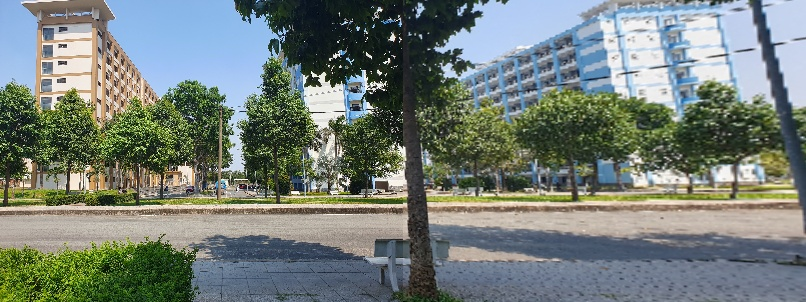

In [90]:
brisk = cv.BRISK.create()

kp1, des1 = brisk.detectAndCompute(imgs[0], None)
kp2, des2 = brisk.detectAndCompute(imgs[1], None)

matcher = cv.BFMatcher()
matches = matcher.knnMatch(des1, des2, k = 2)

matches = np.asarray([match for match in matches if match[0].distance < 0.75 * match[1].distance])

if len(matches[:,0]) < 4:
    raise AssertionError("Can't find enough keypoints.")

src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)

H, masked = cv.findHomography(dst, src, cv.RANSAC, 5.0)

output = cv.warpPerspective(imgs[1], H, (imgs[1].shape[1] + imgs[0].shape[1], imgs[0].shape[0]))
output[0:imgs[0].shape[0], 0:imgs[0].shape[1]] = imgs[0]

display(Image(cv.imencode('.jpg', output)[1].tobytes()))

## Evaluation

- BRISK method give the better features that we can match the two image almost perfectly.
- SIFT method also give the output that quite correct but may need some more transformations and blended technique to match the two images

## Conclusion

- Choose BRISK if speed and real-time processing are priorities, and the images have minimal rotation or scale variations.
- Choose SIFT if high accuracy and robustness are critical, especially for challenging image sets.

## Reference

https://github.com/opencv/opencv/blob/4.x/samples/python/stitching_detailed.py